In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="darkgrid")

x = np.load('/Scr/arango/Sobolev-Hyun/test_simulations/adk_equilibrium/W0test2.pickle', allow_pickle=True)

y = np.load('/Scr/arango/Sobolev-Hyun/test_simulations/adk_equilibrium/W1test2.pickle', allow_pickle=True)
#x = [1, 2, 3, 4, 5]

#sns.lineplot(x)
#plt.show()


In [16]:
print(x)

[0.08070037319439766, 21.55552843937651, 24.365882053845628, 22.863084267796467, 24.578802990227288, 25.90119985640175, 25.015260050490358, 26.561601990231324, 26.415278064207147, 25.26101706896103, 26.792953638439094, 27.653302581289413, 29.501994850435132, 25.031342080618483, 26.352557159107473, 28.14010989552449, 28.652317917656678, 24.323437744630223, 29.108169055429784, 26.43847815370514, 27.292192511933095, 26.89153071375467, 29.642829047396976, 26.34389741978726, 27.709811054665938, 32.543826247066086, 28.60061018330564, 26.348080342618136, 27.796788022138603, 28.185590433700355, 27.544204806636063, 26.98881048701615, 26.94495524227872, 28.438209004742486, 25.254868669078387, 25.65638995566475, 25.35781165267177, 25.128223847286353, 24.364723420266067, 27.0123132847144, 26.25317978521207, 24.798071906784497, 25.081296263590648, 27.014020252547596, 24.117414487461016, 26.781098017594882, 26.1265513262211, 28.589512834357592, 28.407407267221288, 27.42023334884563, 28.1058999402995

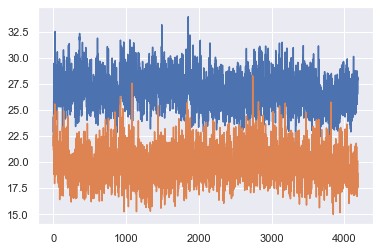

In [24]:
plt.plot(x[1:])
plt.plot(y[1:])
plt.show()

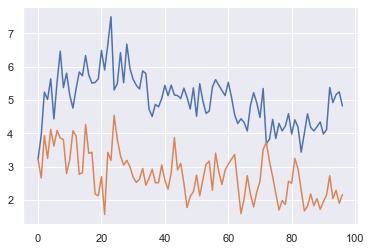

In [29]:
x = np.load('/Scr/arango/Sobolev-Hyun/test_simulations/adk_transitions_DIMS/DIMS/trajectories/W0test_DIMS3.pickle', allow_pickle=True)

y = np.load('/Scr/arango/Sobolev-Hyun/test_simulations/adk_transitions_DIMS/DIMS/trajectories/W1test_DIMS3.pickle', allow_pickle=True)
plt.plot(x[1:])
plt.plot(y[1:])
plt.show()

In [26]:
import persim
import ripser
import MDAnalysis as mda
import argparse
from typing import *
import functools
import itertools 
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis import transformations
import functools
import numpy as np
import torch
import multiprocessing as mp
import time
import ray
import os
import pickle
import collections
import warnings
import curtsies.fmtfuncs as cf
import tqdm

warnings.simplefilter("ignore")

parser = argparse.ArgumentParser()
parser.add_argument('--pdbs', nargs="*", type=str, default="3CLN")
parser.add_argument('--data_dir', type=str, default="/Scr/hyunpark/Monster/vaegan_md_gitlab/data")
parser.add_argument('--pdb', type=str, default=None)
parser.add_argument('--psf', type=str, default=None)
parser.add_argument('--trajs', nargs="*", type=str, default=None) #List of dcds
parser.add_argument('--maxdim', type=int, default=2) #List of dcds
parser.add_argument('--filename', type=str, default="default.npy") #List of dcds
parser.add_argument('--selections', nargs="*", type=str, default="backbone and segid A")
parser.add_argument('--get_cartesian', type=bool, default=True, help="MDA data extraction")
parser.add_argument('--multip', action="store_true", help="enable multiprocessing?")

def persistent_diagram(information: Union[np.ndarray, List[np.ndarray]], maxdim: int):
#     print(information, maxdim)
#     test = ripser.ripser(information[0], maxdim=maxdim)["dgms"][2]
#     print(test)
    Rs_total = list(map(lambda info: ripser.ripser(info, maxdim=maxdim)["dgms"], information ))
    Rs = list(map(lambda rs: rs[maxdim], Rs_total ))
    return Rs, Rs_total

@ray.remote
def wasserstein_mp(pair0: np.ndarray, pair1: np.ndarray):
    w = persim.wasserstein(pair0, pair1)
    return w

@ray.remote
def persistent_diagram_mp(information: Union[np.ndarray, List[np.ndarray]], maxdim: int):
    #Definition of information has changed from List[np.ndarray] to np.ndarray
    #Multiprocessing changes return value from "List of R" to "one R"
    R_total = ripser.ripser(information, maxdim=maxdim)["dgms"]
    R = R_total[maxdim]
    
    summary = collections.namedtuple("summary", ["R", "R_total"])
    summary.R = R
    summary.R_total = R_total
    return summary

class PersistentHomology(object):
    def __init__(self, args: argparse.ArgumentParser):
#         pdbs = args.pdbs
#         selections = args.selections
#         get_cartesian = args.get_cartesian
        
        [setattr(self, key, val) for key, val in args.__dict__.items()]
        
#         self.pdbs = pdbs
#         self.selections = selections
#         self.get_cartesian = get_cartesian

    @staticmethod
    def load_mmtf(pdbs: List[str]):
        us = list(map(lambda pdb: mda.fetch_mmtf(pdb), pdbs)) #List of universes
        return us
    
    @staticmethod
    def traj_preprocessing(prot_traj, prot_ref, align_selection):
        if (prot_traj.trajectory.ts.dimensions is not None): 
            box_dim = prot_traj.trajectory.ts.dimensions
        else:
            box_dim = np.array([1,1,1,90,90,90])
#         print(box_dim, prot_traj.atoms.positions, prot_ref.atoms.positions, align_selection)
        transform = transformations.boxdimensions.set_dimensions(box_dim)
        prot_traj.trajectory.add_transformations(transform)
        AlignTraj(prot_traj, prot_ref, select=align_selection, in_memory=True).run()
        return prot_traj
    
    @staticmethod
    def load_traj(data_dir: str, pdb: str, psf: str, trajs: List[str], selections: List[str]):
        assert (pdb is not None) or (psf is not None), "At least either PDB of PSF should be provided..."
        assert trajs is not None, "DCD(s) must be provided"
        top = pdb if (pdb is not None) else psf
        top = os.path.join(data_dir, top)
        trajs = list(map(lambda inp: os.path.join(data_dir, inp), trajs ))
        universe = mda.Universe(top, *trajs)
        reference = mda.Universe(top)
        print("MDA Universe is created")
#         print(top, universe,reference)
        selections = selections[0]
        prot_traj = PersistentHomology.traj_preprocessing(universe, reference, selections)
        print("Aligned MDA Universe is RETURNED!")

        return reference, prot_traj #universes
    
    @staticmethod
    def get_atomgroups(mda_universes: List[mda.Universe], selections: List[str] = "backbone and segid A"):
        if isinstance(mda_universes, list):
            if len(selections) == 1: 
                print("there is one atom selection criteria...; Applying the same selection for all molecules!")
                selections = selections * len(mda_universes) #proliferate selection of elements same as pdb lists 
            else: 
                print(selections, mda_universes)
                assert len(selections) == len(mda_universes), "number of Universes and selections should match!"

            ags = list(map(lambda u, sel: u.select_atoms(sel), mda_universes, selections ))
            return ags
        else:
            ag = [mda_universes.select_atoms(selections[0])] #Make it into a List of AtomGroup
            return ag #List[one_AtomGroup]
    
    @staticmethod
    def birth_and_death(mda_universes_or_atomgroups: Union[List[mda.Universe], List[mda.AtomGroup]], get_cartesian: bool = True, 
                        selections: List[str] = "backbone and segid A", traj_flag: bool=False, multip: bool=False, maxdim: int=2):
        if isinstance(mda_universes_or_atomgroups[0], mda.Universe):
            ags = PersistentHomology.get_atomgroups(mda_universes_or_atomgroups, selections)
        else:
            ags = mda_universes_or_atomgroups #List of AtomGroups 

        if get_cartesian and len(ags) >= 2 and not traj_flag:
            information = list(map(lambda ag: ag.atoms.positions, ags )) #List of atomgroup positions
        elif get_cartesian and len(ags) == 1 and traj_flag:
            prot_traj = ags[0].universe #back to universe
            coords = AnalysisFromFunction(lambda ag: ag.positions.copy(),
                                   prot_traj.atoms.select_atoms(selections[0])).run().results['timeseries'] #B,L,3
            information = torch.from_numpy(coords).unbind(dim=0) #List of (L,3) Tensors
            information = list(map(lambda inp: inp.detach().cpu().numpy(), information )) #List of (L,3) Arrays
#             information = np.split(coords, indices_or_sections=coords.shape[0], axis=0) #[(L,3)] * B
        else:
            raise NotImplementedError("Not implemented for non-positional information!")
        
#         print(information)
        print("Ripser for DGMS...")
        if not multip:
            print("Normal Ripser...")
            Rs, Rs_total = persistent_diagram(information, maxdim)
#         else:
#             return information
        else:
            print("Multiprocessing Ripser...")
#             with mp.Pool() as pool:
#                 Rs = pool.map(persistent_diagram_mp, information)
            maxdims = [maxdim] * len(information)
            futures = [persistent_diagram_mp.remote(i, maxdim) for i, maxdim in zip(information, maxdims)]
            summaries = ray.get(futures)
#             print(len(summaries))
            Rs_zips = [(summary.R, summary.R_total) for summary in summaries]
            Rs_zip_flats = list(zip(*Rs_zips))
            print(len(Rs_zip_flats))
            Rs = list(Rs_zip_flats[0])
            Rs_total = list(Rs_zip_flats[1])
        return Rs, Rs_total


    @staticmethod
    def get_wassersteins(ripser_objects: List[ripser.ripser], traj_flag: bool=False, multp: bool=False):
        if not traj_flag:
            assert len(ripser_objects) >= 2, "for Wasserstein, it must have more than two Ripser objects!"
            ripser_pair = list(itertools.combinations(ripser_objects, 2))
            wdists = list(map(lambda pair: persim.wasserstein(*pair), ripser_pair ))
            return wdists
        else:
            if not multp:
                wdists = list(map(lambda pair: functools.partial(persim.wasserstein, dgm1=ripser_objects[0])(dgm2 = pair), ripser_objects[slice(1, None)] ))
                return wdists
            else:
                pair1 = ripser_objects[slice(1, None)]
                pair0 = [ripser_objects[0]] * len(pair1)
                futures = [wasserstein_mp.remote(p0, p1) for p0, p1 in zip(pair0, pair1)]
                wdists = ray.get(futures)
                return wdists

    @staticmethod
    def get_wassersteins_pairwise(ripser_objects: List[ripser.ripser], multp: bool=False):
        if not multp:
            firsts = ripser_objects[slice(0,-1)]
            seconds = ripser_objects[slice(1,None)]
            wdists = list(map(lambda first, second: persim.wasserstein(dgm1=first, dgm2=second), firsts, seconds ))
            return wdists
        else:
            firsts = ripser_objects[slice(0,-1)]
            seconds = ripser_objects[slice(1,None)]
            futures = [wasserstein_mp.remote(p0, p1) for p0, p1 in zip(firsts, seconds)]
            wdists = ray.get(futures)
            return wdists        
        
    @property
    def calculate_wdists_pdbs(self, ):
        s = time.time()
        print(self.__dict__)
        
        us = self.load_mmtf(self.pdbs)
        ags = self.get_atomgroups(us, self.selections)
        Rs = self.birth_and_death(ags, self.get_cartesian, self.selections, self.maxdim)
        wdists = self.get_wassersteins(Rs)
        
        e = time.time()
        print(f"Took {e-s} seconds...")
        print("Done!")
        return us, ags, Rs, wdists
    
    @property
    def calculate_wdists_trajs(self, ):
        s = time.time()
        print(self.__dict__)
        
        reference, prot_traj = self.load_traj(self.data_dir, self.pdb, self.psf, self.trajs, self.selections)
        ags_ref = self.get_atomgroups(reference, self.selections)
        ags_trajs = self.get_atomgroups(prot_traj, self.selections)
        traj_flag = (self.trajs is not None)
        
        if os.path.exists(os.path.join(self.data_dir, self.filename)) and os.path.exists(os.path.join(self.data_dir, "WD" + self.filename)) and os.path.exists(os.path.join(self.data_dir, "WP" + self.filename)):
            print(cf.on_yellow("All the necessary files exist... Skipping PH calculation..."))
        else:
            print(cf.on_red("Not all the necessary files exist... Executing PH calculation..."))
            _, Rs_ref_total = self.birth_and_death(ags_ref, self.get_cartesian, self.selections, traj_flag, False, self.maxdim)
            print("Rs for Ref done...")
            _, Rs_trajs_total = self.birth_and_death(ags_trajs, self.get_cartesian, self.selections, traj_flag, self.multip, self.maxdim)
            print("Rs for Trajs done...")
            Rs_total = Rs_ref_total + Rs_trajs_total
        
        if os.path.exists(os.path.join(self.data_dir, self.filename)) and os.path.exists(os.path.join(self.data_dir, "WD" + self.filename)) and os.path.exists(os.path.join(self.data_dir, "WP" + self.filename)):
            print(cf.on_yellow("All the necessary files exist... Loading PH and Wassersteins..."))
            f = open(os.path.join(self.data_dir, "PH" + self.filename), "wb")
            Rs_list = pickle.load(f)
            print(cf.on_yellow(f"Loading diagrams from {"PH" + self.filename}..."))
            f = open(os.path.join(self.data_dir, "WD" + self.filename), "wb")
            wdist_list = pickle.load(f)
            print(cf.on_yellow(f"Loading reference Wasserstein from {"WD" + self.filename}..."))
            f = open(os.path.join(self.data_dir, "WP" + self.filename), "wb")
            wdist_pair_list = pickle.load(f)            
            print(cf.on_yellow(f"Loading pairwise Wasserstein from {"WP" + self.filename}..."))
        else:
            print(cf.on_red("Not all the necessary files exist... Saving PH and Wassersteins..."))
            Rs_list = []
            wdist_list = []
            wdist_pair_list = []
            for maxdim in tqdm.tqdm(range(self.maxdim + 1)):
                print(cf.green(f"Calculating Wasserstein for dimension {maxdim}..."))
                Rs = list(map(lambda inp: inp[maxdim], Rs_total )) #List of array; maxdim chooses which PH dim!
                wdists = self.get_wassersteins(Rs, traj_flag, self.multip) 
                wdist_pairs = self.get_wassersteins_pairwise(Rs, self.multip)
                Rs_list.append(Rs) #List of maxdim numbers where each dimension is a length of len(traj)
                wdist_list.append(wdists) #List of maxdim numbers where each dimension is a length of len(traj)
                wdist_pair_list.append(wdist_pairs) #List of maxdim numbers where each dimension is a length of len(traj)
            f = open(os.path.join(self.data_dir, "PH" + self.filename), "wb")
            pickle.dump(Rs_list, f)   
            print(cf.on_yellow(f"Saving diagrams from {"PH" + self.filename}..."))
            f = open(os.path.join(self.data_dir, "WD" + self.filename), "wb")
            pickle.dump(wdist_list, f) 
            print(cf.on_yellow(f"Saving reference Wasserstein from {"WD" + self.filename}..."))
            f = open(os.path.join(self.data_dir, "WP" + self.filename), "wb")
            pickle.dump(wdist_pair_list, f) 
            print(cf.on_yellow(f"Saving pairwise Wasserstein from {"WP" + self.filename}..."))

        e = time.time()
        print(f"Took {e-s} seconds...")
        print("Done!")
        return [reference, prot_traj], [ags_ref, ags_trajs], Rs_list, (wdist_list, wdist_pair_list)
    
if __name__ == "__main__":
    args = parser.parse_args()
    ph = PersistentHomology(args)
    _, _, Rs, wdists = ph.calculate_wdists_trajs
    print(cf.on_green(f"Rs is a list of PH diagrams corresponding to a dimension...; e.g. Rs[0] gives list of PH diagrams at dimension=0"))
    print(cf.on_green(f"""wdists is a tuple of two lists; each list consists of Wasserstein distances corresponding to a dimension...; 
                      e.g. wdists[0][1] gives a references Wasserstein distances at dimension=1"""))
    
    #Need to calculate wdists for maxdim
    #print(wdists[0], wdists[1])
    #Omitted self.filename for now
#     for i in range(ph.maxdim+1):
#         fd = open(os.path.join(ph.data_dir, "WD"+str(i)+ph.filename), "wb")
#         fp = open(os.path.join(ph.data_dir, "WP"+str(i)+ph.filename), "wb")
#         #f1 = open(os.path.join(ph.data_dir, "W1"+ph.filename), "wb")
#         #print(len(wdist[i]))
#         pickle.dump(wdists[i], fd)
#         pickle.dump(wdist_pairs[i], fp)
#         #pickle.dump(wdists[1], f1)  
    
#     print(cf.on_yellow(f"Saving diagrams from {ph.filename}..."))

    """
    s = time.time()
    print(ph.__dict__)
    reference, prot_traj = ph.load_traj(ph.pdb, ph.psf, ph.trajs, ph.selections)
    ags_ref = ph.get_atomgroups(reference, ph.selections)
    ags_trajs = ph.get_atomgroups(prot_traj, ph.selections)
    traj_flag = (ph.trajs is not None)
    Rs_ref = ph.birth_and_death(ags_ref, ph.get_cartesian, ph.selections, traj_flag)
    print("Rs for Ref done...")
    
    if not ph.multip:
        Rs_trajs = ph.birth_and_death(ags_trajs, ph.get_cartesian, ph.selections, traj_flag, ph.multip)
        print("Rs for Trajs done...")
    else:
        information = ph.birth_and_death(ags_trajs, ph.get_cartesian, ph.selections, traj_flag, ph.multip)
#         print(information)
        print("Multiprocessing Ripser...")
#         time.sleep(10)
#         with mp.Pool() as pool:
#             Rs_trajs = pool.map(persistent_diagram_mp, information)
        futures = [persistent_diagram_mp.remote(i) for i in information]
        Rs_trajs = ray.get(futures)
        print("Rs for Trajs done...")
        
    Rs = Rs_ref + Rs_trajs 
    wdists = ph.get_wassersteins(Rs, traj_flag)
    
    print(wdists)
    e = time.time()
    print(f"Took {e-s} seconds...")
    print("Done!")
    """
